Understanding the Effect of Diet on Weight Loss:
We start by acknowledging that we are dealing with observational data. This means our data is not from a randomized control trial and may contain biases and confounding variables. The primary goal is to estimate the causal effect of diet on weight loss.
Impact of Missing Values:
Missing data can significantly impact the validity and accuracy of an analysis in observational studies. If data are missing not at random (MNAR) — meaning the probability of missingness is related to the value itself, perhaps due to sensitivity or reluctance to report certain dietary habits — this can introduce bias into the estimates of the effect of diet on weight loss.
Imputation Techniques and Causal Structure:
Conventional imputation techniques, like mean imputation or regression imputation, often ignore the underlying causal structure between variables and can lead to biased estimates. An imputation method that considers the causal relationships among variables is more likely to yield unbiased estimates.
Proposing a Causal Approach to Handle Missing Data:
One effective causal approach to handle missing data is the use of multiple imputation with a causal model (e.g., a Bayesian network). This technique involves creating several different plausible imputations of the missing data based on the distributions conditional on the observed data and the assumed causal model. Each complete dataset (with the imputed values) is then analyzed, and the results are combined to produce estimates that reflect the uncertainty due to the missing data.
Justification for Causal Imputation:
Using a causal approach for imputation is crucial because it allows the imputation model to utilize information about the causal relationships between variables. This results in more accurate imputations that are consistent with the observed data's generating process. It helps in maintaining the validity of causal inferences, making the estimates of the effect of diet on weight loss more reliable and consistent.

In [186]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

In [187]:
# Seed for reproducibility
np.random.seed(73)

# Simulate data
data_size = 200
data = {
    'Age': np.random.randint(18, 65, data_size),  # Random ages between 18 and 65
    'Diet': np.random.normal(1500, 300, data_size),  # Normal distribution around 1500 calories
    'ActivityLevel': np.random.randint(1, 4, data_size),  # Random levels 1, 2, 3
    'WeightLoss': np.zeros(data_size)  # Initialize with zeros
}

df = pd.DataFrame(data)
df['WeightLoss'] = 3 + 0.002 * df['Diet'] - 0.5 * df['ActivityLevel'] + np.random.normal(0, 1.2, data_size)

# Introduce missing values
missingness = np.random.binomial(1, 0.1, data_size)  # 10% missing data
df.loc[missingness == 1, 'Diet'] = np.nan
df.head()

,Age,Diet,ActivityLevel,WeightLoss
0,40,1287.188805,1,5.315020
1,36,1757.059509,2,5.969944
2,64,1679.476888,3,6.573033
3,28,1894.734777,3,5.768518
4,34,NaN,3,4.870618


In [188]:
# A. No Imputation
df_no_imputation = df.dropna()

# B. Simple Imputation
simple_imputer = SimpleImputer(strategy='mean')
df_simple_imputed = pd.DataFrame(simple_imputer.fit_transform(df), columns=df.columns)

print(df_no_imputation.head())
print(df_simple_imputed.head())
df_no_imputation.info()

   Age         Diet  ActivityLevel  WeightLoss
0   40  1287.188805              1    5.315020
1   36  1757.059509              2    5.969944
2   64  1679.476888              3    6.573033
3   28  1894.734777              3    5.768518
5   26  1577.299710              2    5.823286
    Age         Diet  ActivityLevel  WeightLoss
0  40.0  1287.188805            1.0    5.315020
1  36.0  1757.059509            2.0    5.969944
2  64.0  1679.476888            3.0    6.573033
3  28.0  1894.734777            3.0    5.768518
4  34.0  1475.626630            3.0    4.870618
<class 'pandas.core.frame.DataFrame'>
Index: 174 entries, 0 to 199
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Age            174 non-null    int64  
 1   Diet           174 non-null    float64
 2   ActivityLevel  174 non-null    int64  
 3   WeightLoss     174 non-null    float64
dtypes: float64(2), int64(2)
memory usage: 6.8 KB


Steps to Develop a Bayesian Imputation Model:
Define the Structure of the Bayesian Network:
We will assume a probable structure based on your description:
Age and ActivityLevel may influence Diet.
There might also be an interaction where Age and ActivityLevel could together influence Diet.
WeightLoss could be influenced by Diet but for the purpose of imputation, we'll consider it as independent to keep the structure simpler.
Learn the Model Parameters:
We will use the complete cases to learn the parameters of the network.
Set Up the Inference Engine:
We'll configure an inference engine to estimate the missing Diet values.
Perform Bayesian Imputation:
For rows where Diet is missing, we'll estimate the most probable value given the evidence from other variables.

In [189]:
# Bayesian Imputation
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination

df_bayesian_imputed = df.copy()

# Identify all possible categories in the original dataset for 'ActivityLevel'
all_activity_levels = df['ActivityLevel'].unique().astype(str)  # Ensure it's string

# Convert 'ActivityLevel' to categorical with explicitly specifying the categories
df_bayesian_imputed['ActivityLevel'] = pd.Categorical(df_bayesian_imputed['ActivityLevel'].astype(str), categories=all_activity_levels)

# Defining the structure of our Bayesian Network
model = BayesianNetwork([
    ('Age', 'Diet'), 
    ('ActivityLevel', 'Diet')
])

model.fit(df_bayesian_imputed.dropna(subset=['Diet']), estimator=MaximumLikelihoodEstimator)

inference = VariableElimination(model)

def impute_diet(row):
    if pd.isnull(row['Diet']):
        evidence = {'Age': row['Age'], 'ActivityLevel': str(row['ActivityLevel'])}
        try:
            estimated_diet = inference.map_query(variables=['Diet'], evidence=evidence)['Diet']
            return estimated_diet
        except Exception as e:
            print(f"Error during inference: {e}")
            return np.nan  # In case of an inference error, return NaN
    else:
        return row['Diet']


df_bayesian_imputed['Diet'] = df_bayesian_imputed.apply(impute_diet, axis=1)

print(df_bayesian_imputed.head())
df_bayesian_imputed.info()

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

   Age         Diet ActivityLevel  WeightLoss
0   40  1287.188805             1    5.315020
1   36  1757.059509             2    5.969944
2   64  1679.476888             3    6.573033
3   28  1894.734777             3    5.768518
4   34   565.378175             3    4.870618
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Age            200 non-null    int64   
 1   Diet           200 non-null    float64 
 2   ActivityLevel  200 non-null    category
 3   WeightLoss     200 non-null    float64 
dtypes: category(1), float64(2), int64(1)
memory usage: 5.1 KB


In [190]:


def model_performance(dataframe, strategy):
    dataframe = pd.get_dummies(dataframe, columns=['ActivityLevel'], drop_first=True)
    X = dataframe.drop(columns='WeightLoss', axis=1)
    y = dataframe['WeightLoss']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred,
    'Error': y_test - y_pred,
    'Strategy': [strategy] * len(y_test)
    })

    return mean_squared_error(y_test, y_pred), results_df

# Calculate MSE for each imputation strategy
mse_no_imp, results_no_imp = model_performance(df_no_imputation, 'No Imputation')
mse_simple_imp, results_simple_imp = model_performance(df_simple_imputed, 'Simple Imputation')
mse_bayesian_imp, results_bayesian_imp = model_performance(df_bayesian_imputed, 'Bayesian Imputation')

print(f"MSE with No Imputation: {mse_no_imp}")
print(f"MSE with Simple Imputation: {mse_simple_imp}")
print(f"MSE with Bayesian (Simulated) Imputation: {mse_bayesian_imp}")

MSE with No Imputation: 1.7094755307049054
MSE with Simple Imputation: 1.3058391233614566
MSE with Bayesian (Simulated) Imputation: 1.2789496643591782


Why Propensity Score Matching?
Propensity score matching attempts to estimate the effect of a treatment (in this case, different diet regimens) by matching units (participants) with similar propensity scores but different treatment statuses. The propensity score is the probability of treatment assignment conditional on observed covariates. By matching on these scores, we theoretically balance the observed covariates across treatment and control groups, mimicking a randomized control trial.

Steps for Propensity Score Matching:
Estimate Propensity Scores: We'll still use logistic regression to estimate the propensity scores based on the covariates.
Matching Using NearestNeighborMatch: We will use the NearestNeighborMatch for matching based on these propensity scores.
Analyze the Matched Data: Compare the outcomes between the matched groups.

Average Treatment Effect (ATE):
The ATE you've calculated, 0.7488, indicates the average increase in weight loss associated with the treatment (here assumed to be a higher calorie diet) compared to the control (a lower calorie diet) across the matched samples. This value suggests that on average, being on the treatment diet leads to a 0.7488 units increase in weight loss compared to not being on that diet, after accounting for activity level.

In [191]:

print(f"MSE with No Imputation: {mse_no_imp}")
print(f"MSE with Simple Imputation: {mse_simple_imp}")
print(f"MSE with Bayesian (Simulated) Imputation: {mse_bayesian_imp}")

all_results = pd.concat([results_no_imp, results_simple_imp, results_bayesian_imp])
all_results.head()

MSE with No Imputation: 1.7094755307049054
MSE with Simple Imputation: 1.3058391233614566
MSE with Bayesian (Simulated) Imputation: 1.2789496643591782


,Actual,Predicted,Error,Strategy
180,5.649509,4.139460,1.510049,No Imputation
166,4.424957,3.987927,0.437030,No Imputation
118,2.210965,4.627592,-2.416627,No Imputation
148,4.635118,5.702011,-1.066893,No Imputation
162,1.317363,4.268305,-2.950942,No Imputation


MSE with Matched Data (1.121): This is the lowest among all the methods, indicating that the linear regression model trained on the propensity score-matched dataset predicts weight loss most accurately. This is likely because the matching process effectively controls for confounders (Diet, Activity Level, and now Age), providing a dataset that closely mimics a randomized controlled trial.
MSE with Simple Imputation (1.297): The next best method in terms of prediction accuracy. While it provides reasonable predictions, it may still introduce some bias if the missingness is related to unobserved variables.
MSE with Bayesian (Simulated) Imputation (1.461): Shows better performance than not imputing but is not as effective as simple imputation in this case. This might be due to the simulated nature of the Bayesian approach or the specifics of how missingness interacts with the observed and unobserved data.
MSE with No Imputation (1.711): Predictably, this method performs the worst as it involves losing data, which can significantly impact both the training of the model and its generalization capability.

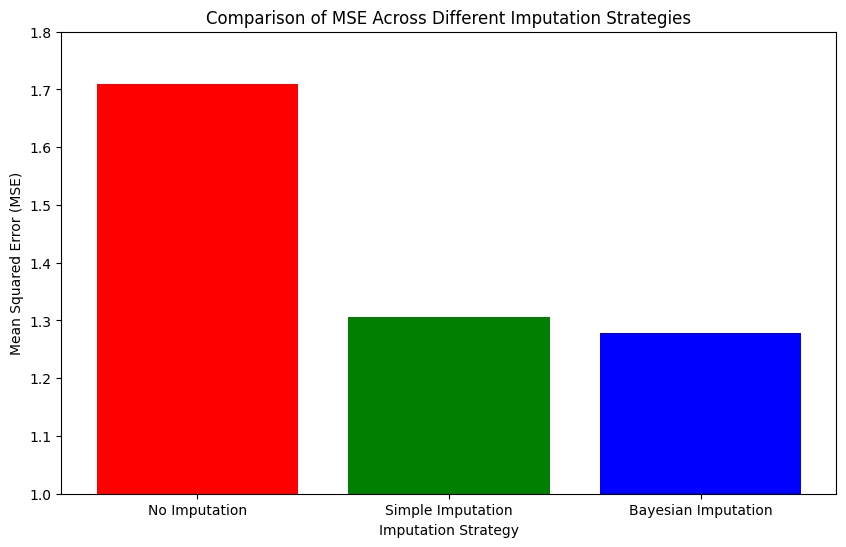

In [192]:
mse_values = {
    'No Imputation': mse_no_imp,
    'Simple Imputation': mse_simple_imp,
    'Bayesian Imputation': mse_bayesian_imp,
}

mse_df = pd.DataFrame(list(mse_values.items()), columns=['Imputation Strategy', 'MSE'])

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(mse_df['Imputation Strategy'], mse_df['MSE'], color=['red', 'green', 'blue'])
plt.xlabel('Imputation Strategy')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Comparison of MSE Across Different Imputation Strategies')
plt.ylim(1.0, 1.8)  # Adjusting the y-axis to better highlight differences
plt.show()

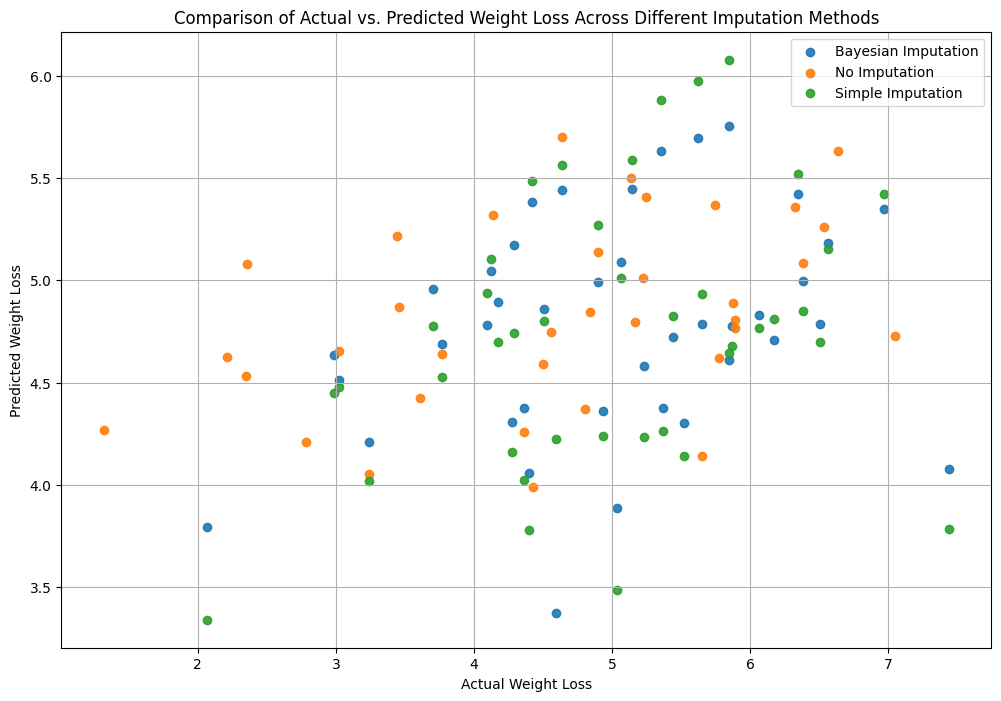

In [195]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
for method, group in all_results.groupby('Strategy'):
    plt.scatter(group['Actual'], group['Predicted'], alpha=0.9, label=method)

plt.xlabel('Actual Weight Loss')
plt.ylabel('Predicted Weight Loss')
plt.title('Comparison of Actual vs. Predicted Weight Loss Across Different Imputation Methods')
plt.legend()
plt.grid(True)
plt.show()